# Подключение библиотеки

In [1]:
import os
import re
import sys
import time
import uuid
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import display, HTML, Markdown

# Метрики
from sklearn.metrics import mean_squared_error
# Нейросети
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [2]:
try:
    from TorchDiffEqPack.odesolver import odesolve
except:
    !pip install TorchDiffEqPack

    from TorchDiffEqPack.odesolver import odesolve

# Импорт и анализ данных

In [3]:
try:
    df = pd.read_csv('Amp_C_train.txt')
except:
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
            
    df = pd.read_csv(os.path.join(dirname, filename))

##### Рассмотрим содержимое датасет

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172032 entries, 0 to 172031
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    172032 non-null  float64
 1   Input   172032 non-null  object 
 2   Output  172032 non-null  object 
dtypes: float64(1), object(2)
memory usage: 3.9+ MB


# Машинное обучение

In [5]:
# Проверка наличия CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if device.type == 'cuda':
    print("CUDA is available!")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA capability: {torch.cuda.get_device_capability(0)}")
    print(f"Driver version: {torch.version.cuda}")
    print(f"Device count: {torch.cuda.device_count()}")
    print(f"Current device: {torch.cuda.current_device()}")
else:
    print("CUDA is not available. Running on CPU.")

CUDA is available!
Device name: NVIDIA GeForce GTX 1650 Ti
CUDA capability: (7, 5)
Driver version: 12.1
Device count: 1
Current device: 0


### Neural Ordinary Differential Equations (Neural ODE)

#### Инициализация класса модели

In [6]:
class NeuralODETrainer:
    def __init__(self, df, batch_size=64, learning_rate=0.001, epochs=10, hidden_layers=[64, 128, 256, 128], method='dopri5', device=None):
        """
        Инициализация класса NeuralODETrainer для обучения и оценки модели.

        Args:
            df (pd.DataFrame): Входные данные в формате pandas DataFrame.
            batch_size (int, optional): Размер батча для обучения. По умолчанию 64.
            learning_rate (float, optional): Скорость обучения для оптимизатора. По умолчанию 0.001.
            epochs (int, optional): Количество эпох для обучения. По умолчанию 10.
            hidden_layers (list, optional): Конфигурация скрытых слоев в модели. По умолчанию [64, 128, 256, 128].
            method (str, optional): Метод интеграции для решения ODE. По умолчанию 'dopri5'.
            device (str, optional): Устройство для выполнения вычислений ('cpu' или 'cuda'). По умолчанию None.
        """
        # Преобразуем данные
        self.df = self.prepare_data(df)
        self.device = self.get_device(device)
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.hidden_layers = hidden_layers
        self.method = method
        self.history = {"epoch": [], "rmse": []}  # История обучения
        # Генерация уникального ID при создании экземпляра класса
        self.model_id = str(uuid.uuid4())

        # Подготовка данных
        self.dataset = TensorDataset(
            torch.tensor(self.df.index.values, dtype=torch.float32),
            torch.tensor(self.df[['input_real', 'input_imag']].values, dtype=torch.float32),
            torch.tensor(self.df[['output_real', 'output_imag']].values, dtype=torch.float32),
        )
        self.train_loader = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=True, num_workers=0, pin_memory=True)
        
        # Инициализация модели
        self.model = self.NeuralODEModel(hidden_layers=self.hidden_layers).to(self.device)
        self.criterion = nn.MSELoss()  # Используем MSE как функцию потерь
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

    @staticmethod
    def get_device(select=None):
        """
        Получает устройство для вычислений (CPU или GPU).

        Args:
            select (str, optional): Выбор устройства ('cpu', 'gpu' или 'cuda'). По умолчанию None.

        Returns:
            torch.device: Устройство для выполнения вычислений.
        """
        if select is None or select == 'gpu' or select == 'cuda':
            if torch.cuda.is_available():
                # print('Using GPU (CUDA)')
                return torch.device('cuda')
            else:
                # print("CUDA not available, falling back to CPU.")
                return torch.device('cpu')
        # CPU
        else:
            # print('Using CPU')
            return torch.device('cpu')

    @staticmethod
    def prepare_data(df):
        """
        Преобразует исходные данные в нужный формат.

        Args:
            df (pd.DataFrame): Входные данные с колонками 'Input', 'Output' и 'Time'.

        Returns:
            pd.DataFrame: Обработанный DataFrame с раздельными вещественными и мнимыми частями.
        """
        df['Input'] = df['Input'].apply(lambda x: complex(x))  # Преобразуем строки в комплексные числа
        df['Output'] = df['Output'].apply(lambda x: complex(x))
        df['input_real'] = df['Input'].apply(lambda x: x.real)
        df['input_imag'] = df['Input'].apply(lambda x: x.imag)
        df['output_real'] = df['Output'].apply(lambda x: x.real)
        df['output_imag'] = df['Output'].apply(lambda x: x.imag)
        df = df.drop(['Input', 'Output'], axis=1)
        df = df.set_index('Time')  # Устанавливаем временной ряд как индекс
        return df

    class ODEFunc(nn.Module):
        def __init__(self, hidden_size):
            """
            Инициализация ODE функции с двумя слоями и нормализацией.

            Args:
                hidden_size (int): Размер скрытого слоя для ODE функции.
            """
            super().__init__()
            self.fc1 = nn.Linear(hidden_size, hidden_size)
            self.fc2 = nn.Linear(hidden_size, hidden_size)
            self.relu = nn.ReLU()
            self.norm = nn.LayerNorm(hidden_size)  # Добавляем нормализацию
    
        def forward(self, t, x):
            """
            Прямой проход через ODE функцию.

            Args:
                t (torch.Tensor): Временная точка.
                x (torch.Tensor): Входные данные.

            Returns:
                torch.Tensor: Результат применения ODE функции.
            """
            x = self.relu(self.fc1(x))
            x = self.norm(x)  # Применяем нормализацию
            return self.relu(self.fc2(x))

    class NeuralODEModel(nn.Module):
        def __init__(self, input_size=2, hidden_layers=[2**4, 2**6, 2**5], output_size=2):
            """
            Инициализация модели Neural ODE с заданными слоями.

            Args:
                input_size (int, optional): Размер входного слоя. По умолчанию 2.
                hidden_layers (list, optional): Список размеров скрытых слоев. По умолчанию [2**4, 2**6, 2**5].
                output_size (int, optional): Размер выходного слоя. По умолчанию 2.
            """
            super().__init__()
            self.input_layer = nn.Linear(input_size, hidden_layers[0])
            
            self.hidden_layers = nn.ModuleList([])
            self.residual_connections = nn.ModuleList([]) # Добавляем список для преобразований residual
            for i in range(len(hidden_layers) - 1):
                self.hidden_layers.append(nn.Linear(hidden_layers[i], hidden_layers[i + 1]))
                # Линейное преобразование для residual, если размерности не совпадают
                if hidden_layers[i] != hidden_layers[i + 1]: 
                    self.residual_connections.append(nn.Linear(hidden_layers[i], hidden_layers[i + 1]))
                else:
                    self.residual_connections.append(nn.Identity()) # Идентичное преобразование, если размерности совпадают
    
            self.ode_func = NeuralODETrainer.ODEFunc(hidden_layers[-1])
            self.output_layer = nn.Linear(hidden_layers[-1], output_size)
            self.dropout = nn.Dropout(p=0.5)

        def forward(self, x, t):
            """
            Прямой проход через модель.

            Args:
                x (torch.Tensor): Входные данные.
                t (torch.Tensor): Временные точки.

            Returns:
                torch.Tensor: Прогнозируемые значения.
            """
            x = self.input_layer(x)
            for layer, residual_layer in zip(self.hidden_layers, self.residual_connections): # Итерируемся по слоям и преобразованиям
                residual = x
                x = torch.relu(layer(x)) 
                x = self.dropout(x)
                x += residual_layer(residual)  # Применяем преобразование к residual перед сложением
                
            options = {
                'method': 'dopri5',  # метод решения (адаптивный шаг)
                't0': t[0].item(),  # начальное время
                't1': t[-1].item(),  # конечное время
                'rtol': 1e-9,  # относительная точность
                'atol': 1e-10,  # абсолютная точность
                'print_neval': False,  # не выводить количество итераций
                'neval_max': 1e7,  # максимальное число итераций
                't_eval': t[-1:],  # Берем только последний элемент t
                'regenerate_graph': False  # не перегенерировать граф для обратного прохода
            }
            
            x = odesolve(self.ode_func, x, options=options)
            x = x.squeeze(0)  # Удаляем первую размерность
            x = self.output_layer(x)

            assert x.shape[1] == 2, f"Error: 2 output values are expected, received {x.shape[1]}"

            return x

    def train(self):
        """
        Обучает модель Neural ODE на заданных данных.
        """
        self.model.train()
    
        for epoch in range(self.epochs):
            running_loss = 0.0
            rmse_total = 0.0
            progress_bar = tqdm(self.train_loader, desc=f"Epoch {epoch+1}/{self.epochs}", unit="batch")
    
            for batch_idx, (t, inputs, targets) in enumerate(progress_bar):
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                t = t.to(self.device)
                self.optimizer.zero_grad()
    
                outputs = self.model(inputs, t)
                loss = self.criterion(outputs, targets)
                rmse = torch.sqrt(loss)  # RMSE
                rmse.backward()
                self.optimizer.step()
    
                # Рассчитываем RMSE
                rmse_total += rmse.item()
    
                progress_bar.set_postfix(rmse=f"{rmse:.6f}")
    
            avg_rmse = rmse_total / len(self.train_loader)
            
            # Сохраняем метрики в историю
            self.history["epoch"].append(epoch + 1)
            self.history["rmse"].append(avg_rmse)
    
            print(f"Epoch {epoch+1}/{self.epochs} completed with RMSE: {avg_rmse:.6f}")
    
        print("Training completed!")

    def evaluate(self):
        """
        Оценка модели на обучающем наборе данных.
        
        Returns:
            tuple: Значения RMSE для реальных и мнимых частей, предсказанные значения.
        """
        self.model.eval()
        true_values = []
        predicted_values = []
        times = []
    
        with torch.no_grad():
            for t, inputs, targets in self.train_loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                t = t.to(self.device)
                outputs = self.model(inputs, t)
                true_values.append(targets.cpu().numpy())
                predicted_values.append(outputs.cpu().numpy())
                times.append(t.cpu().numpy())
    
        # Конкатенация всех предсказанных значений, истинных значений и временных меток
        self.true_values = np.concatenate(true_values, axis=0)
        self.predicted_values = np.concatenate(predicted_values, axis=0)
        self.times = np.concatenate(times, axis=0)
    
        # Сортировка данных по временам
        sort_indices = np.argsort(self.times)
        self.times = self.times[sort_indices]
        self.true_values = self.true_values[sort_indices]
        self.predicted_values = self.predicted_values[sort_indices]
            
        # Проверяем размерности и удаляем лишние, если необходимо
        if len(self.true_values.shape) == 3 and self.true_values.shape[1] == 1:
            self.true_values = self.true_values.squeeze(1)
        if len(self.predicted_values.shape) == 3 and self.predicted_values.shape[1] == 1:
            self.predicted_values = self.predicted_values.squeeze(1)
    
        # Проверяем размерности после удаления лишних размерностей
        assert self.true_values.shape[1] == 2, f"True values should have shape (n_samples, 2), but got {self.true_values.shape}"
        assert self.predicted_values.shape[1] == 2, f"Predicted values should have shape (n_samples, 2), but got {self.predicted_values.shape}"

        # Вычисление RMSE
        rmse_real = mean_squared_error(self.true_values[:, 0], self.predicted_values[:, 0], squared=False)
        rmse_imag = mean_squared_error(self.true_values[:, 1], self.predicted_values[:, 1], squared=False)

        print(f"Evaluation RMSE (Real): {rmse_real:.6f}")
        print(f"Evaluation RMSE (Imaginary): {rmse_imag:.6f}")
    
        return rmse_real, rmse_imag, self.predicted_values

    def save_model_pt(self, filename_prefix='node', save_dir='models'):
        """
        Сохраняет всю модель PyTorch в формате .pt.

        Args:
            filename_prefix (str, optional): Префикс имени файла. По умолчанию 'node'.
            save_dir (str, optional): Директория для сохранения модели. По умолчанию 'models'.
        """
        # Создаем папку, если ее нет
        os.makedirs(save_dir, exist_ok=True)

        # Генерируем имя файла с текущей датой и временем
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{filename_prefix}_{timestamp}_{self.model_id}.pt"

        # Полный путь к файлу
        filepath = os.path.join(save_dir, filename)

        # Сохраняем ВСЮ модель
        torch.save(self.model, filepath)

    # Не используем это, зависает ноутбук
    def save_model_onnx(self, filename_prefix='node', save_dir='models'):
        """
        Экспортирует модель в формате ONNX (Open Neural Network Exchange).

        Args:
            filename_prefix (str, optional): Префикс имени файла. По умолчанию 'node'.
            save_dir (str, optional): Директория для сохранения модели. По умолчанию 'models'.
        """
        # Создаем папку, если ее нет
        os.makedirs(save_dir, exist_ok=True)

        # Генерируем имя файла с текущей датой и временем
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{filename_prefix}_{timestamp}_{self.model_id}.onnx"
        
        dummy_input = torch.randn(self.batch_size, 2).to(self.device)  # Размерность входа (batch_size, 2)
        # Временные точки (размерность равна количеству строк в DataFrame)
        dummy_t = torch.arange(0, len(self.df), dtype=torch.float32).to(self.device) 

        # Экспорт модели в ONNX
        torch.onnx.export(
            self.model,                        # Модель для экспорта
            (dummy_input, dummy_t),             # Пример входных данных
            filename,                   # Путь для сохранения ONNX модели
            input_names=["input", "t"],         # Имена входных данных 
            output_names=["output"],          # Имя выходных данных
            dynamic_axes={'input': {0: 'batch_size'},   # Динамические оси
                            't': {0: 'time_steps'}} 
        )

    def save_prediction(self, predictions, filename_prefix="predictions", save_dir='history'):
        """
        Сохраняет предсказанные значения в формате CSV.

        Args:
            predictions (np.ndarray): Предсказанные значения.
            filename_prefix (str, optional): Префикс имени файла. По умолчанию 'predictions'.
            save_dir (str, optional): Директория для сохранения файла. По умолчанию 'history'.
        """
        # Создаем папку, если ее нет
        os.makedirs(save_dir, exist_ok=True)

        # Генерируем имя файла с текущей датой и временем
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{filename_prefix}_{timestamp}_{self.model_id}.csv"

        # Полный путь к файлу
        filepath = os.path.join(save_dir, filename)
        
        df_predictions = pd.DataFrame({'real': predictions[:, 0], 'imag': predictions[:, 1],})
        df_predictions.to_csv(filepath, index=False)
        print(f"Training history saved to {filepath}")

    def save_training_history(self, filename_prefix="training_history", save_dir='history'):
        """
        Сохраняет историю обучения модели в формате CSV.

        Args:
            filename_prefix (str, optional): Префикс имени файла. По умолчанию 'training_history'.
            save_dir (str, optional): Директория для сохранения файла. По умолчанию 'history'.
        """
        # Создаем папку, если ее нет
        os.makedirs(save_dir, exist_ok=True)

        # Генерируем имя файла с текущей датой и временем
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{filename_prefix}_{timestamp}_{self.model_id}.csv"

        # Полный путь к файлу
        filepath = os.path.join(save_dir, filename)
        
        df_history = pd.DataFrame(self.history)
        df_history.to_csv(filepath, index=False)
        print(f"Training history saved to {filepath}")

    def plot_training_history(self):
        """
        Строит графики истории обучения модели, отображая RMSE на каждой эпохе.
        """
        fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
        # Преобразуем список эпох для оси X
        epochs = self.history["epoch"]
    
        # Первый график: Полная история
        axs[0].plot(epochs, self.history["rmse"], marker='o', linestyle='-', color='b', markersize=5, label='RMSE')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Average Loss')
        axs[0].set_title('Loss Function (Full History)')
        axs[0].grid(True)
        axs[0].legend()

        # Второй график: Половина истории
        mid_index = len(epochs) // 2
        axs[1].plot(epochs[mid_index:], self.history["rmse"][mid_index:], marker='o', linestyle='-', color='b', markersize=5, label='RMSE')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Average RMSE')
        axs[1].set_title('Loss Function (Second Half of Training)')
        axs[1].grid(True)
        axs[1].legend()
    
        plt.tight_layout()
        plt.show()

    def plot_predictions(self, time_start=0, time_end=1.005e2):
        """
        Строит графики истинных и предсказанных значений для реальной и мнимой частей в выбранном временном диапазоне.

        Args:
            time_start (float, optional): Начальное время. По умолчанию 0.
            time_end (float, optional): Конечное время. По умолчанию 1.005e2.
        """
        # Убедимся, что данные были вычислены в evaluate()
        if not hasattr(self, 'true_values') or not hasattr(self, 'predicted_values') or not hasattr(self, 'times'):
            raise ValueError("You must run evaluate() before plotting predictions.")
    
        # Фильтрация данных по времени
        mask = (self.times >= time_start) & (self.times <= time_end)
        filtered_times = self.times[mask]
        filtered_true_values = self.true_values[mask, :]  
        filtered_predicted_values = self.predicted_values[mask, :]
    
        # Построение графика для реальных значений
        plt.figure(figsize=(20, 5))
    
        plt.subplot(1, 2, 1)  # 1 ряд, 2 колонки, 1-й график
        plt.plot(filtered_times, filtered_true_values[:, 0], label="True Real", linestyle='-', color='red')
        plt.plot(filtered_times, filtered_predicted_values[:, 0], label="Predicted Real", linestyle='-', color='blue')
        plt.legend()
        plt.title("True vs Predicted Real Values")
        plt.xlabel("Time")
        plt.ylabel("Real Value")
    
        # Построение графика для мнимых значений
        plt.subplot(1, 2, 2)  # 1 ряд, 2 колонки, 2-й график
        plt.plot(filtered_times, filtered_true_values[:, 1], label="True Imag", linestyle='-', color='red')
        plt.plot(filtered_times, filtered_predicted_values[:, 1], label="Predicted Imag", linestyle='-', color='blue')
        plt.legend()
        plt.title("True vs Predicted Imaginary Values")
        plt.xlabel("Time")
        plt.ylabel("Imaginary Value")
    
        plt.tight_layout()
        plt.show()

    def print_model_summary(self, filename_prefix="model_parameters", save_dir='history'):
        """
        Выводит информацию о модели и сохраняет её параметры и их размерности в CSV файл.

        Args:
            filename_prefix (str, optional): Префикс имени файла. По умолчанию 'model_parameters'.
            save_dir (str, optional): Директория для сохранения файла. По умолчанию 'history'.
        """
        # Создаем папку, если ее нет
        os.makedirs(save_dir, exist_ok=True)

        # Генерируем имя файла с текущей датой и временем
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{filename_prefix}_{timestamp}_{self.model_id}.csv"

        # Полный путь к файлу
        filepath = os.path.join(save_dir, filename)
        
        df_params = pd.DataFrame(columns=['Parameter name', 'Parameter shape', 'Parameter count'])
        
        print(f"Model architecture: {self.model}")
        print("-" * 50)

        total_params = 0
        for name, param in self.model.named_parameters():
            print(f"Parameter name: {name}")
            print(f"Parameter shape: {param.shape}")
            param_count = torch.numel(param)
            print(f"Parameter count: {param_count}")
            print("-" * 30)

            # Добавляем информацию о параметре в DataFrame
            df_params.loc[len(df_params)] = [name, param.shape, param_count] 
            
            total_params += param_count

        print(f"Total trainable parameters: {total_params}")
        print("=" * 50)
        
        # Сохраняем DataFrame в CSV файл
        df_params.to_csv(filepath, index=False)

#### Установка параметров

In [7]:
batch_size=1024*1
learning_rate=1e-4
epochs=10
layers=[64, 128, 256, 128]

In [8]:
# Создание экземпляра класса с настройкой гиперпараметров
NODE_model = NeuralODETrainer(df, batch_size, learning_rate, epochs, layers)

In [9]:
NODE_model.print_model_summary()

Model architecture: NeuralODEModel(
  (input_layer): Linear(in_features=2, out_features=64, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (residual_connections): ModuleList(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (ode_func): ODEFunc(
    (fc1): Linear(in_features=128, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (relu): ReLU()
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (output_layer): Linear(in_features=128, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
--------------------------------------------------
Parameter name: input_layer.weight
Parameter 

#### Обучение модели

In [10]:
%%time
NODE_model.train()

Epoch 1/10: 100%|█████████████████████████████████| 168/168 [00:05<00:00, 31.56batch/s, rmse=0.514825]


Epoch 1/10 completed with RMSE: 0.817034


Epoch 2/10: 100%|█████████████████████████████████| 168/168 [00:04<00:00, 34.67batch/s, rmse=0.344595]


Epoch 2/10 completed with RMSE: 0.409952


Epoch 3/10: 100%|█████████████████████████████████| 168/168 [00:04<00:00, 34.29batch/s, rmse=0.296269]


Epoch 3/10 completed with RMSE: 0.321483


Epoch 4/10: 100%|█████████████████████████████████| 168/168 [00:05<00:00, 31.90batch/s, rmse=0.263835]


Epoch 4/10 completed with RMSE: 0.282077


Epoch 5/10: 100%|█████████████████████████████████| 168/168 [00:04<00:00, 37.17batch/s, rmse=0.250351]


Epoch 5/10 completed with RMSE: 0.261618


Epoch 6/10: 100%|█████████████████████████████████| 168/168 [00:05<00:00, 32.58batch/s, rmse=0.236076]


Epoch 6/10 completed with RMSE: 0.246803


Epoch 7/10: 100%|█████████████████████████████████| 168/168 [00:05<00:00, 32.01batch/s, rmse=0.235408]


Epoch 7/10 completed with RMSE: 0.236314


Epoch 8/10: 100%|█████████████████████████████████| 168/168 [00:05<00:00, 31.45batch/s, rmse=0.218585]


Epoch 8/10 completed with RMSE: 0.228032


Epoch 9/10: 100%|█████████████████████████████████| 168/168 [00:05<00:00, 30.24batch/s, rmse=0.220781]


Epoch 9/10 completed with RMSE: 0.221180


Epoch 10/10: 100%|████████████████████████████████| 168/168 [00:05<00:00, 31.03batch/s, rmse=0.210755]

Epoch 10/10 completed with RMSE: 0.215081
Training completed!
CPU times: user 1min 4s, sys: 2.06 s, total: 1min 6s
Wall time: 51.6 s


In [11]:
NODE_model.save_training_history()

Training history saved to history/training_history_20241013_201900_7a186688-7ebd-4838-aada-fb9398c71026.csv


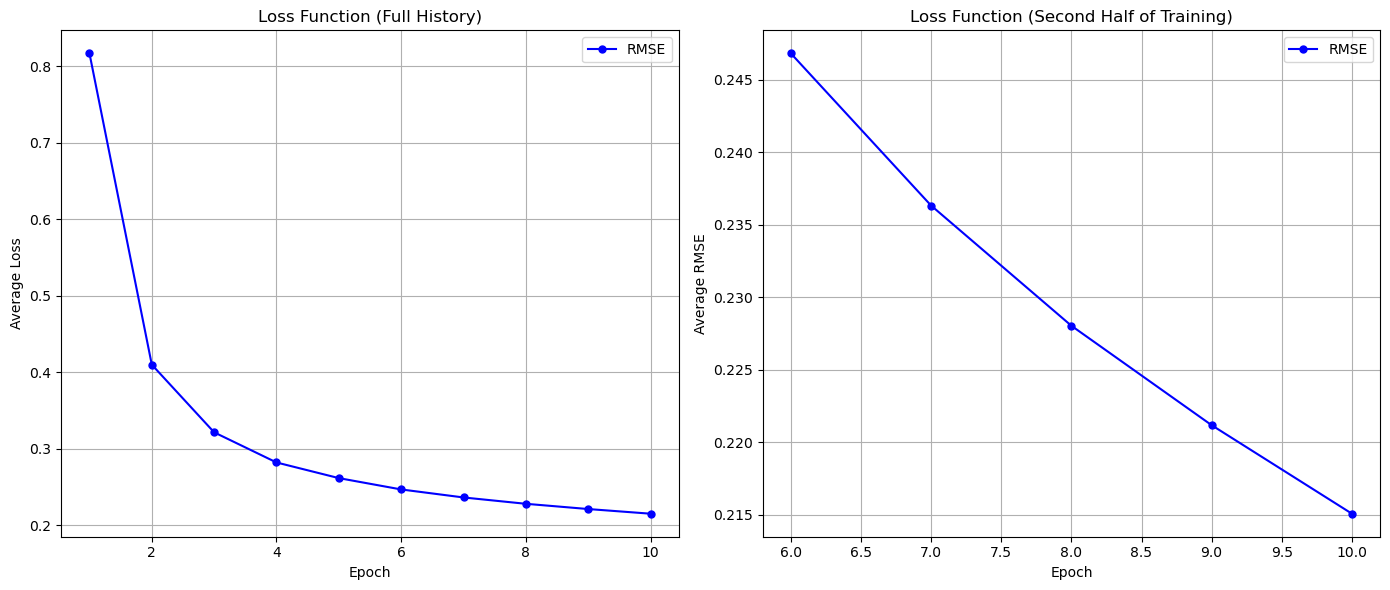

In [12]:
NODE_model.plot_training_history()

#### Предсказание и сохранение модели после обучения

In [13]:
%%time
rmse_real, rmse_imag, predictions = NODE_model.evaluate()

Evaluation RMSE (Real): 0.132513
Evaluation RMSE (Imaginary): 0.136250
CPU times: user 5.21 s, sys: 169 ms, total: 5.38 s
Wall time: 3.82 s


In [14]:
print(f"Evaluation RMSE (Real): {rmse_real:.6f}")
print(f"Evaluation RMSE (Imaginary): {rmse_imag:.6f}")

Evaluation RMSE (Real): 0.132513
Evaluation RMSE (Imaginary): 0.136250


#### Сохранение модели

In [15]:
NODE_model.save_model_pt()

#### Демонстрация

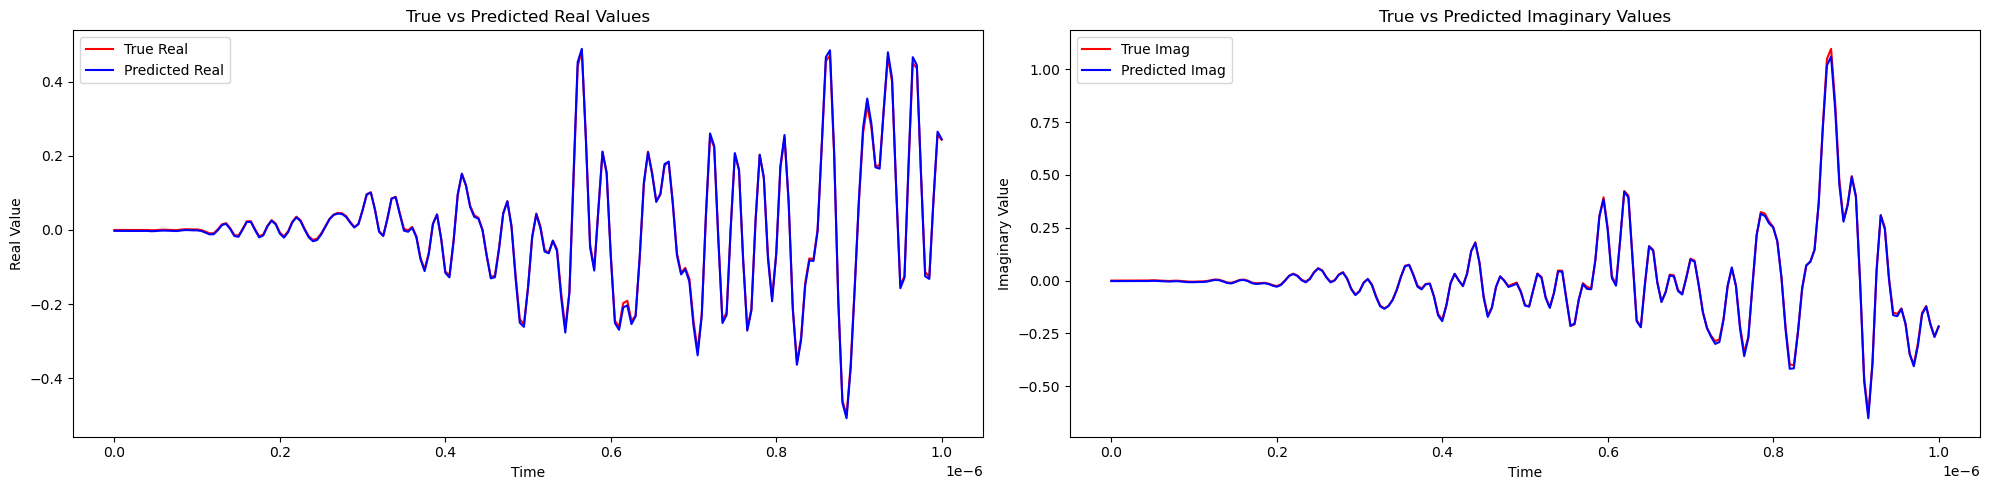

CPU times: user 1.15 s, sys: 109 ms, total: 1.26 s
Wall time: 251 ms


In [16]:
%%time
NODE_model.plot_predictions(time_start=0, time_end=0.1e-5)

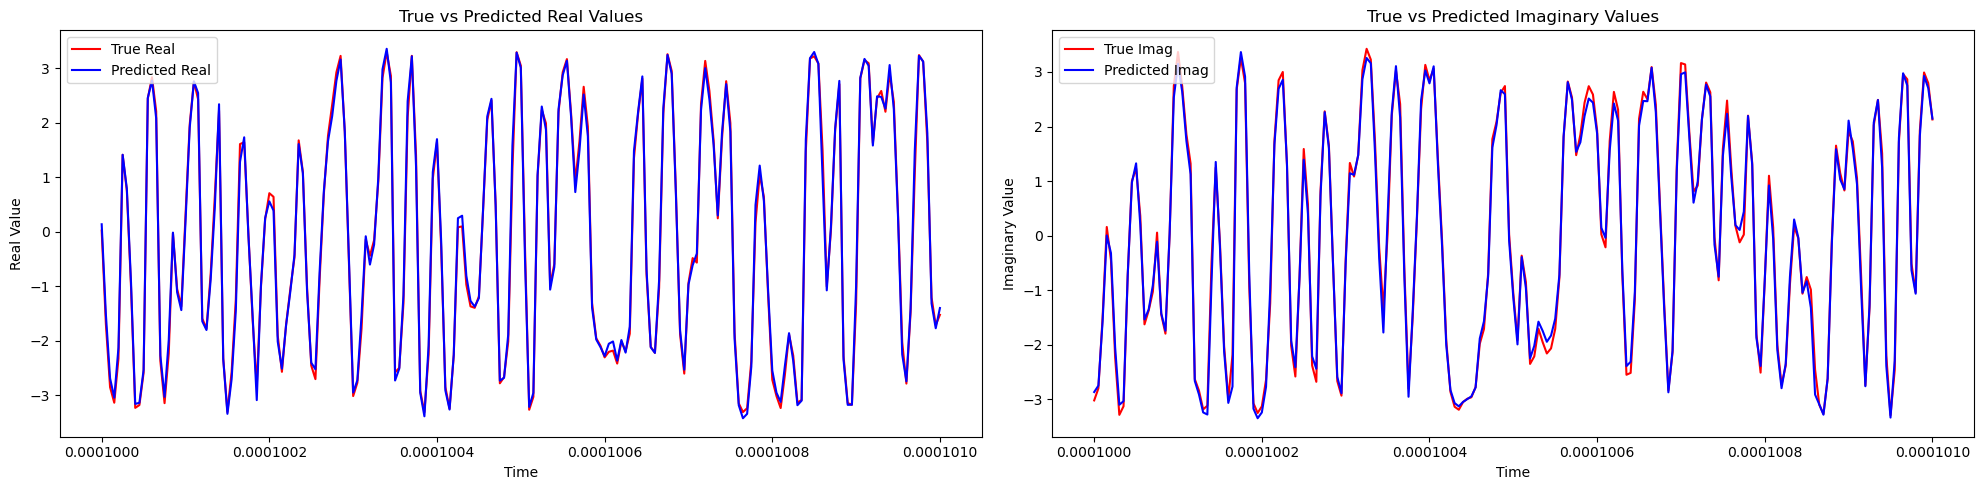

CPU times: user 267 ms, sys: 4.08 ms, total: 271 ms
Wall time: 269 ms


In [17]:
%%time
NODE_model.plot_predictions(time_start=1e-4, time_end=1.01e-4)

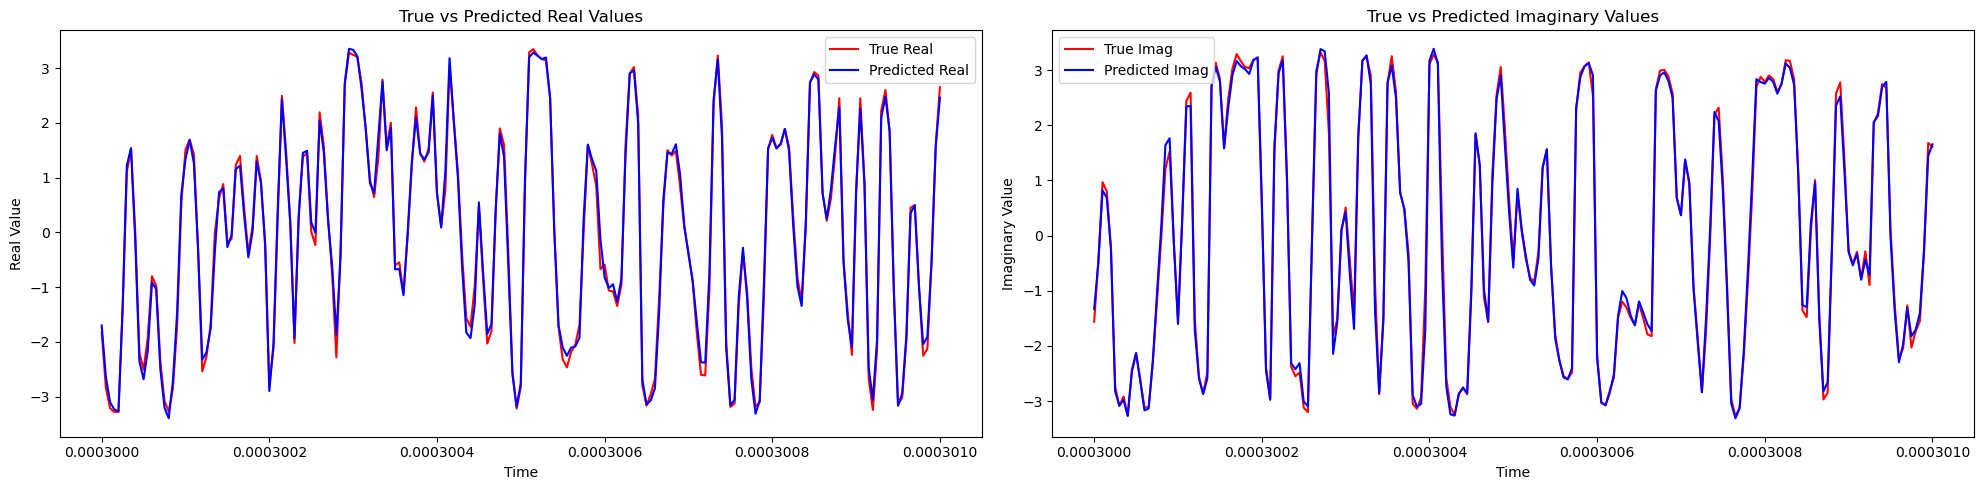

CPU times: user 261 ms, sys: 7.97 ms, total: 269 ms
Wall time: 266 ms


In [18]:
%%time
NODE_model.plot_predictions(time_start=3e-4, time_end=3.01e-4)

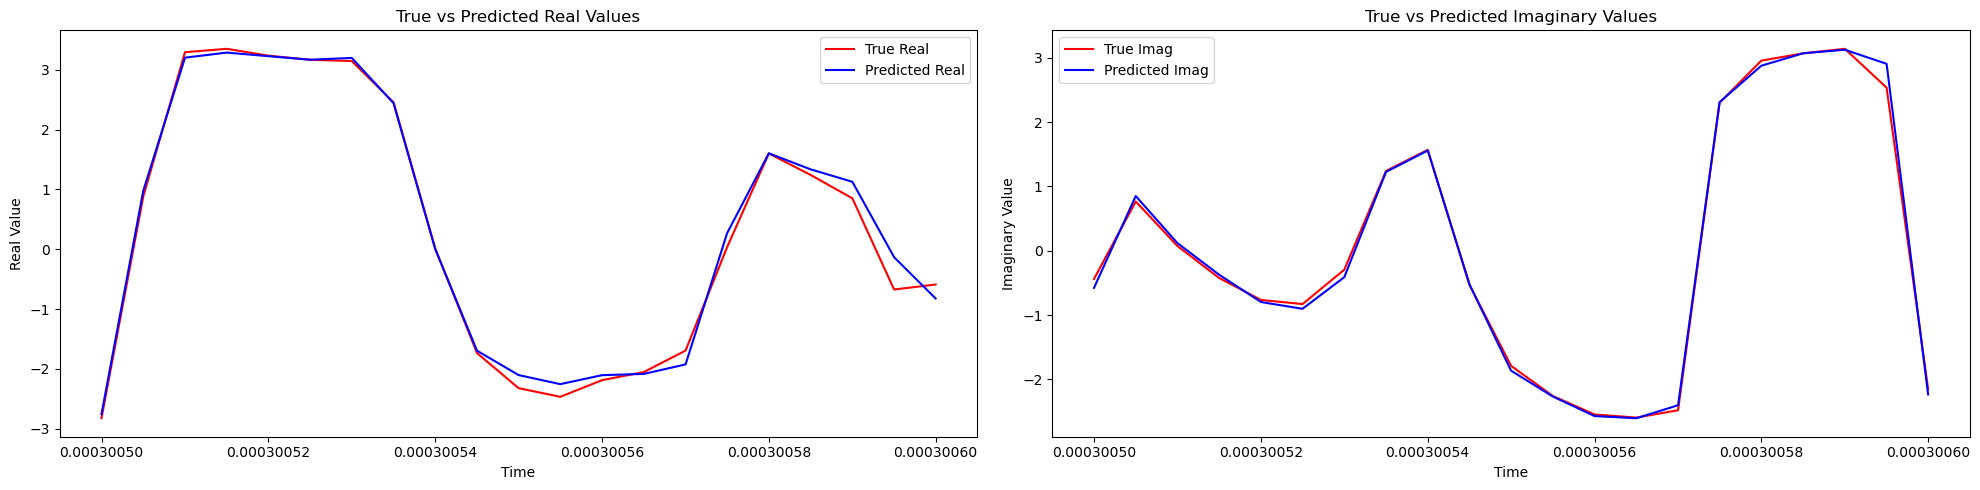

CPU times: user 236 ms, sys: 7.99 ms, total: 244 ms
Wall time: 241 ms


In [19]:
%%time
NODE_model.plot_predictions(time_start=3.005e-4, time_end=3.006e-4)